In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from typing import Tuple

plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

# Funciones

In [3]:
def fourier_transform(t: np.ndarray, v: np.ndarray) -> Tuple[np.ndarray]:

    # Le restamos el valor medio
    v = v-np.mean(v)

    transformada_0 = np.fft.fft(v)

    largo = len(t) # miro la cantidad de elementos que tiene el vector de ts
    d_t = np.mean(np.diff(t)) # miro los diferenciales de t entre mediciones
    frecuencia = np.fft.fftfreq(largo,d_t)
    frecuencia_max = 1/d_t # pregunta: ¿tiene sentido que la frecuencia máxima sea esta y no otra?
    # frecuencia = np.linspace(0, frecuencia_max, largo) # mi vector de frecuencias va de cero hasta la frecuencia máxima
    #y es del mismo largo que todos las demás
    transformada_a = np.abs(transformada_0) # le tomo el valor absoluto a la transformada,

    # Sacamos las frecuencias negativas 
    frecuencia = frecuencia[np.arange(largo//2)]
    transformada_a = transformada_a[np.arange(largo//2)]

    return frecuencia, transformada_a

def calculate_fourier_freqs(t: np.ndarray, V: np.ndarray) -> Tuple[np.ndarray]:
    no_off_V = V - np.mean(V)

    frec, tf = fourier_transform(t,no_off_V)
    tf = tf/max(tf)

    peaks, _ = find_peaks(tf, distance= 15)

    frec_peaks = frec[peaks]
    tf_peaks = tf[peaks]
    
    return frec_peaks, tf_peaks

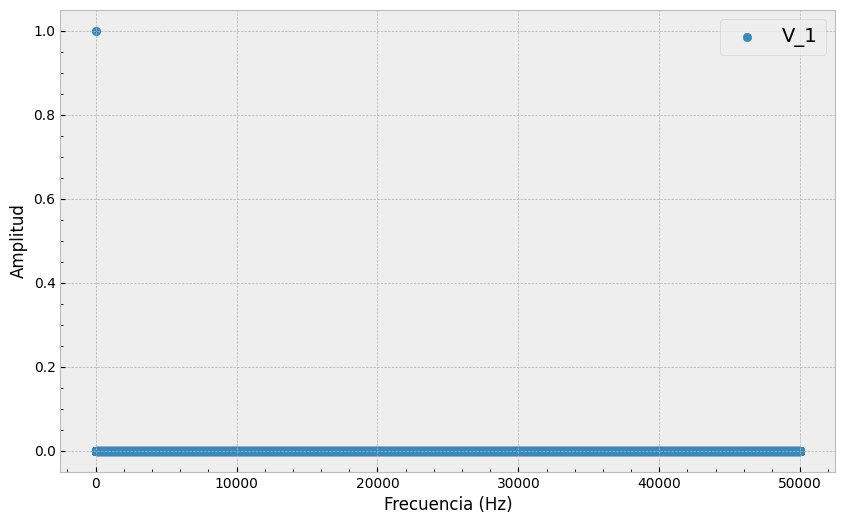

100001 la f es 49998.500014999845
49998.500014999845


In [4]:
t_final = 1
dt = 1/100000
t = np.arange(0,t_final+dt,dt)
# t = np.linspace(0,1,1000)
V = np.sin(2*np.pi*1*t)
# plt.figure()
# plt.scatter(t, V)
# plt.show()

frec, tf = fourier_transform(t,V)
tf = tf/max(tf)

fig,axs = plt.subplots(ncols = 1, figsize = (10,6))


axs.scatter(frec, tf, label='V_1')
axs.set_xlabel('Frecuencia (Hz)')
axs.set_ylabel('Amplitud')
axs.legend(fontsize = 14)
axs.legend(fontsize = 14)
plt.show()

n = len(t)
print(len(t),"la f es", ((n-1)/2-1)/(n*dt))
print(max(frec))

# 1er método - Calculando el tiempo que tarda en estabilizarse la señal desde que la mandamos

In [5]:
file_name = "../mediciones/D.D/Tiempo de respuesta del laser/0.5 Hz 0.5 Amp 2 OFFS 50 Ohms.pickle"
# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

offset = 2

In [6]:
t_1, V_1 = dic[f"{offset}V"]["t_1"],dic[f"{offset}V"]["V_1"]
t_2, V_2 = dic[f"{offset}V"]["t_2"],dic[f"{offset}V"]["V_2"]

## Visualizando las mediciones

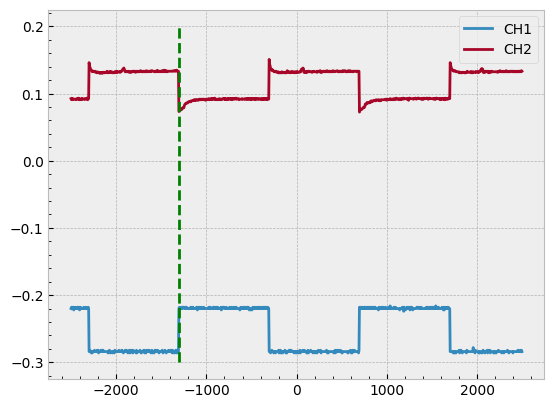

In [7]:
plt.plot(t_1, V_1, label = "CH1")
plt.plot(t_2, V_2, label = "CH2")
plt.vlines(-1305, ymin = -0.3, ymax = 0.2, ls = "--", color = "g")
# plt.xlim(-1320,-1300)
plt.legend()
plt.show()

## Reescaleando las señales

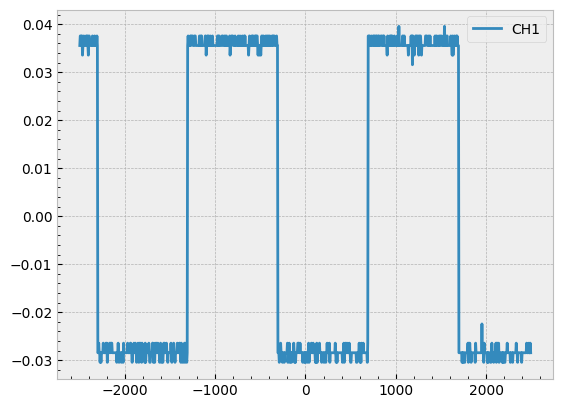

In [8]:
plt.plot(t_1, V_1-np.mean(V_1), label = "CH1")
plt.legend()
plt.show()

In [9]:
V_1_shifted = V_1-np.mean(V_1)
V_1_max = np.mean(V_1_shifted[V_1_shifted > 0])
V_1_min  = np.mean(V_1_shifted[V_1_shifted < 0])

V_1_amp = (V_1_max-V_1_min)/2
print(V_1_amp)

0.032272940422442095


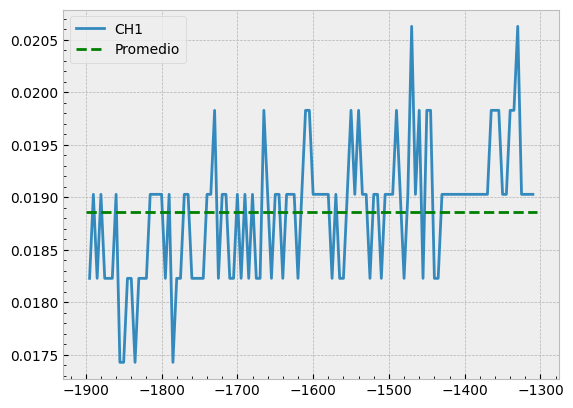

In [10]:
# Hallando el máximo
plt.plot(t_2[(-1305 > t_2) & (t_2 > -1900)], (V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)]),xmin = -1900, xmax = -1305, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

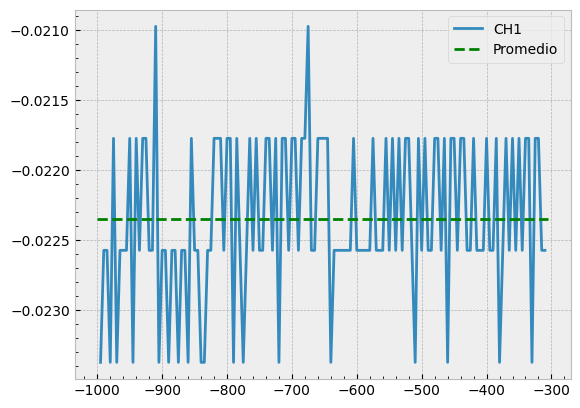

In [11]:
# Hallando el mínimo
t_max = -305
t_min = -1000
plt.plot(t_2[(t_max > t_2) & (t_2 > t_min)], (V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)], label = "CH1")
plt.hlines(np.mean((V_2-np.mean(V_2))[(t_max > t_2) & (t_2 > t_min)]),xmin = t_min, xmax = t_max, ls = "--", color = "g", label = "Promedio")
plt.legend()
plt.show()

In [12]:
V_2_max = np.mean((V_2-np.mean(V_2))[(-1305 > t_2) & (t_2 > -1900)])
V_2_min  = np.mean((V_2-np.mean(V_2))[(-305 > t_2) & (t_2 > -1000)])

V_2_amp = (V_2_max-V_2_min)/2
print(V_2_amp)

0.020602210759027267


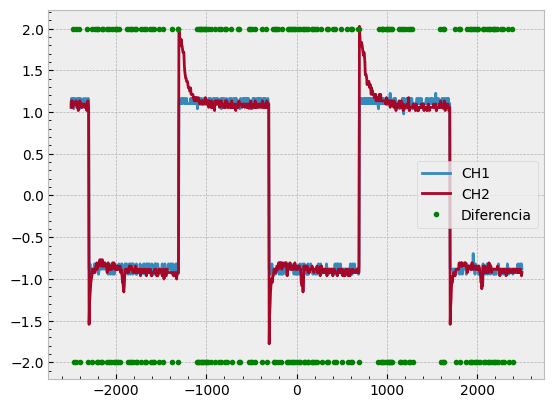

In [13]:
V_1_reescaled = (V_1-np.mean(V_1))/V_1_amp
V_2_reescaled = -(V_2-np.mean(V_2))/V_2_amp

channel_diff = np.diff(np.sign(V_2_reescaled - V_1_reescaled))
index = np.argwhere(channel_diff).flatten()

plt.plot(t_1, V_1_reescaled, label = "CH1")
plt.plot(t_2, V_2_reescaled, label = "CH2")
plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
plt.legend()
plt.show()

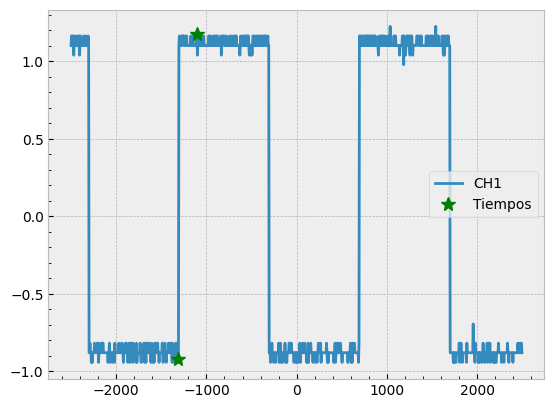

In [14]:
ind_r = index[(t_2[index] > -1200)][0]
ind_s = index[(t_2[index] < -1200)][-1]

plt.plot(t_1, V_1_reescaled, label = "CH1")
# plt.plot(t_2[index], V_2_reescaled[index], label = "CH2", marker = ".", ls = "")
# plt.plot(t_1[index], channel_diff[index],".", color = "g", label = "Diferencia")
# plt.plot(t_1[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], V_2_reescaled[index][:-1][(V_2_reescaled[index][1:] > 0) & (V_2_reescaled[index][:-1] < 0)], color = "g")
plt.plot(t_2[np.array([ind_r,ind_s])], V_2_reescaled[np.array([ind_r,ind_s])], c='g', label='Tiempos', marker = "*", ls = "", ms = 10)
plt.legend()
plt.show()

In [15]:
abs(np.diff(t_2[np.array([ind_r,ind_s])]))[0]*1e-3

0.2

In [16]:
t_r = t_2[index][(t_2[index] > -1200)][0]
t_s = t_2[index][(t_2[index] < -1200)][-1]

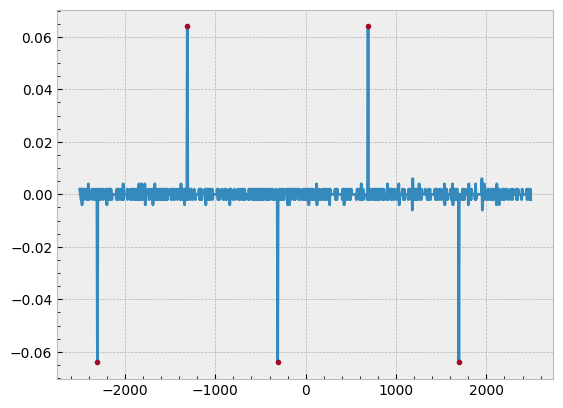

In [17]:
plt.plot(t_1[:-1],np.diff(V_1))
plt.plot(t_1[:-1][np.abs(np.diff(V_1)) > 0.01],np.diff(V_1)[np.abs(np.diff(V_1)) > 0.01],".")
plt.show()

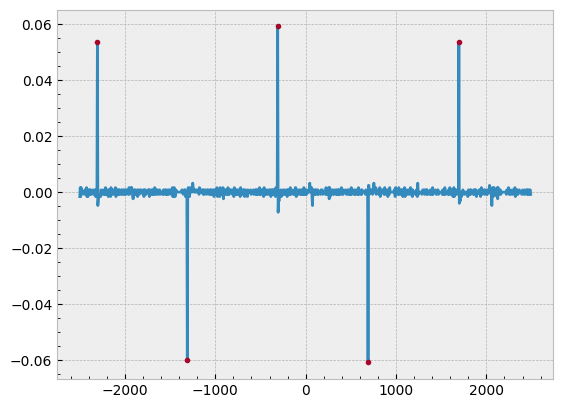

In [18]:
plt.plot(t_2[:-1],np.diff(V_2))
plt.plot(t_2[:-1][np.abs(np.diff(V_2)) > 0.01],np.diff(V_2)[np.abs(np.diff(V_2)) > 0.01],".")
plt.show()

# 2do método - Calculando el ancho de banda de la transformada de Fourier de la señal


## Automatizado

In [19]:
amps, offsets = [1,0.5], [1, 2]
tiempos = ["10 us", "1 ms", "10 ms", "100 ms"]

t_rta_dict = {}
t_rta_list= []
t_med_list = []
for amp, offset in zip(amps, offsets):
    for tiempo in tiempos:
        file_name = f"../mediciones/D.D/Tiempo de respuesta del laser/T_rta 2 Hz {amp} Amp {offset} OFFS {tiempo}.pickle "
        # Cargamos los datos
        with open(file_name, "rb") as f:
            dic = pickle.load(f)

        t_1, V_1, t_2, V_2 = [dic[f"{offset}V"][key] for key in dic[f"{offset}V"].keys()]
        t_1, t_2 = t_1/1000, t_2/1000 # Porque están en milisegundos

        frec_1_peaks, tf_1_peaks = calculate_fourier_freqs(t_1, V_1)
        frec_2_peaks, tf_2_peaks = calculate_fourier_freqs(t_2, V_2)

        frec_2, tf_2 = fourier_transform(t_2, V_2)

        t_rta = 1/(frec_2_peaks[-1]-frec_2_peaks[0])
        print(tf_2_peaks[-1])
        # print("El tiempo de medicion es", t_2[-1]-t_2[0], "mientras el tiempo de respuesta es",t_rta)
        # print(f"El tiempo de respuesta es {t_rta}")

        # print(f"La f calculada es {498/max(t_2)/2} y en realidad es {frec_2[-1]}")

        print(f"El espaciado entre frecuencias es {499/(1000*max(t_2))} y la real es {np.mean(np.diff(frec_2))}")
        # t_rta_dict[f"{amp} amp {offset} OFFS {tiempo}"] = t_rta
        t_rta_list.append(t_rta)
        t_med_list.append(max(t_2)-min(t_2))

# print("T_rta en ms \n",t_rta_dict.values())

0.005984284783720052
El espaciado entre frecuencias es 5000.0 y la real es 5000.0
0.003515663829107929
El espaciado entre frecuencias es 50.0 y la real es 50.0
0.005977588213436073
El espaciado entre frecuencias es 4.999999999999999 y la real es 4.999999999999999
0.016201149552386072
El espaciado entre frecuencias es 0.5 y la real es 0.5
0.005213369348137327
El espaciado entre frecuencias es 5000.0 y la real es 5000.0
0.0037410821254356924
El espaciado entre frecuencias es 50.0 y la real es 50.0
0.003616444778589988
El espaciado entre frecuencias es 4.999999999999999 y la real es 4.999999999999999
0.013634060633854483
El espaciado entre frecuencias es 0.5 y la real es 0.5


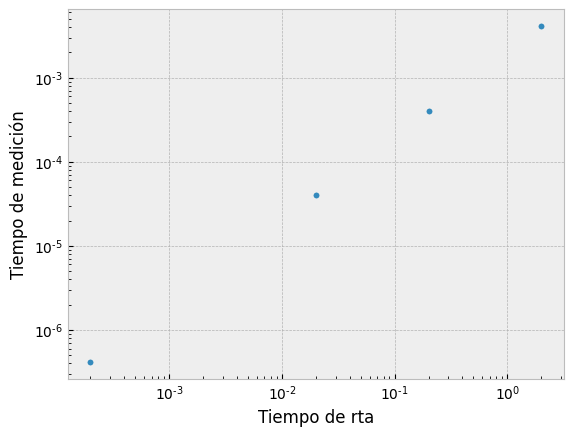

In [20]:
plt.plot(t_med_list, t_rta_list, ".")
plt.xlabel("Tiempo de rta")
plt.ylabel("Tiempo de medición")
plt.xscale("log")
plt.yscale("log")
plt.show()

## Para una medición en particular

In [21]:
amp = 1
offset = 1
tiempo = "10 us"
file_name = f"../mediciones/D.D/Tiempo de respuesta del laser/T_rta 2 Hz {amp} Amp {offset} OFFS {tiempo}.pickle "
# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

In [22]:
t_1, V_1, t_2, V_2 = [dic[f"{offset}V"][key] for key in dic[f"{offset}V"].keys()]
t_1, t_2 = t_1/1000, t_2/1000 # Porque están en milisegundos

### Visualizando las mediciones

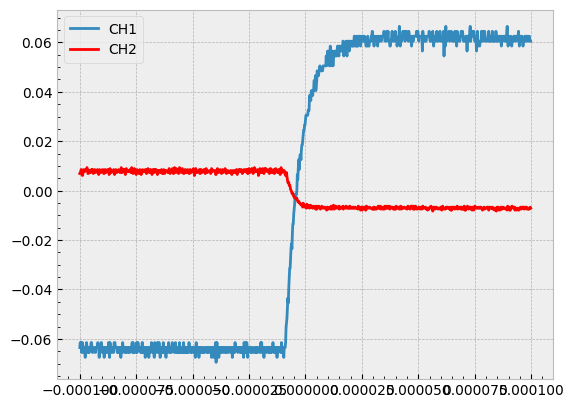

In [23]:
no_off_V_1 = V_1 - np.mean(V_1)
no_off_V_2 = V_2 - np.mean(V_2)

plt.plot(t_1, no_off_V_1, label = "CH1")
plt.plot(t_2, no_off_V_2, label = "CH2", color = "r")
plt.legend()
plt.show()

## Cálculo del rise time

El rise time es de 0.014599999999999998 ms


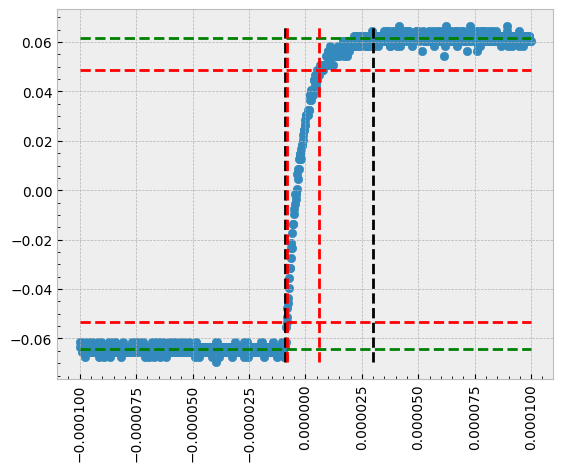

In [46]:
i_salto = 455
i_rise = 650
min_no_off_V_1 = np.mean(no_off_V_1[:i_salto])
max_no_off_V_1 = np.mean(no_off_V_1[i_rise:])

V_1_10_percent = (max_no_off_V_1 - min_no_off_V_1)*0.1 + min_no_off_V_1
V_1_90_percent = (max_no_off_V_1 - min_no_off_V_1)*0.9 + min_no_off_V_1

idx_bajo = np.argwhere(np.diff(np.sign(no_off_V_1 - V_1_10_percent))).flatten()[0]
idx_alto = np.argwhere(np.diff(np.sign(no_off_V_1 - V_1_90_percent))).flatten()[0]

t_bajo, t_alto = t_1[idx_bajo], t_1[idx_alto]
rise_time = t_alto - t_bajo
print(f'El rise time es de {rise_time*1000} ms')

plt.scatter(t_1, no_off_V_1)
plt.vlines(t_1[i_salto], ymin=np.min(no_off_V_1), ymax=np.max(no_off_V_1), ls='--', colors='k', label = "Tiempo donde se termina/arranca el promedio")
plt.vlines(t_1[i_rise], ymin=np.min(no_off_V_1), ymax=np.max(no_off_V_1), ls='--', colors='k')
plt.hlines(min_no_off_V_1, xmin=np.min(t_1), xmax=np.max(t_1), ls='--', colors='g', label = "Tensiones promedio")
plt.hlines(max_no_off_V_1, xmin=np.min(t_1), xmax=np.max(t_1), ls='--', colors='g')
plt.vlines(t_bajo, ymin=np.min(no_off_V_1), ymax=np.max(no_off_V_1), ls='--', colors='r', label = "Intervalo entre el 10 y 90%")
plt.vlines(t_alto, ymin=np.min(no_off_V_1), ymax=np.max(no_off_V_1), ls='--', colors='r')
plt.hlines(no_off_V_1[idx_bajo], xmin=np.min(t_1), xmax=np.max(t_1), ls='--', colors='r')
plt.hlines(no_off_V_1[idx_alto], xmin=np.min(t_1), xmax=np.max(t_1), ls='--', colors='r')
# plt.legend(framealpha = 1)
plt.xticks(rotation = 90)
plt.show()

### Transformamos en Fourier

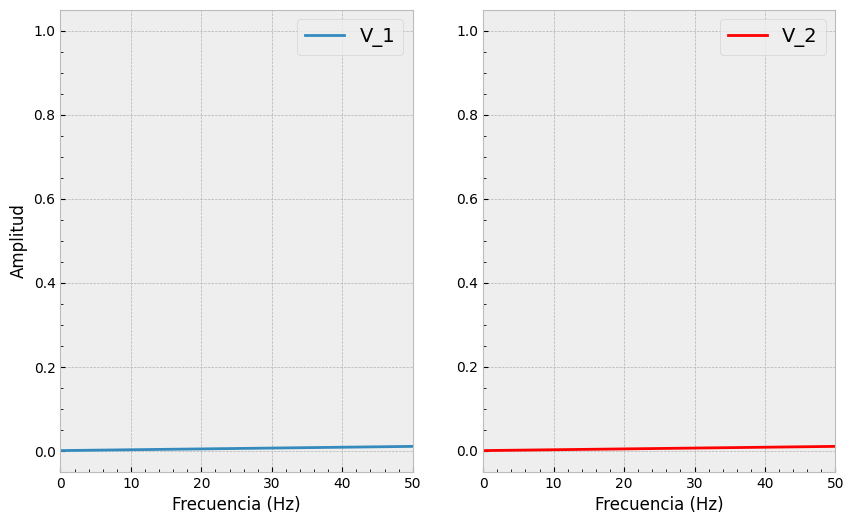

In [25]:
frec_1, tf_1 = fourier_transform(t_1,no_off_V_1)
tf_1 = tf_1/max(tf_1)

frec_2, tf_2 = fourier_transform(t_2,no_off_V_2)
tf_2 = tf_2/max(tf_2)

fig,axs = plt.subplots(ncols = 2, figsize = (10,6))


axs[0].plot(frec_1[tf_1 > 0.0], tf_1[tf_1 > 0.0], label='V_1')
axs[1].plot(frec_2[tf_2 > 0.0], tf_2[tf_2 > 0.0], label='V_2', color = "r")

axs[0].set_xlabel('Frecuencia (Hz)')
axs[1].set_xlabel('Frecuencia (Hz)')
axs[0].set_ylabel('Amplitud')
axs[0].set_xlim(0,50)
axs[1].set_xlim(0,50)
axs[0].legend(fontsize = 14)
axs[1].legend(fontsize = 14)
plt.show()

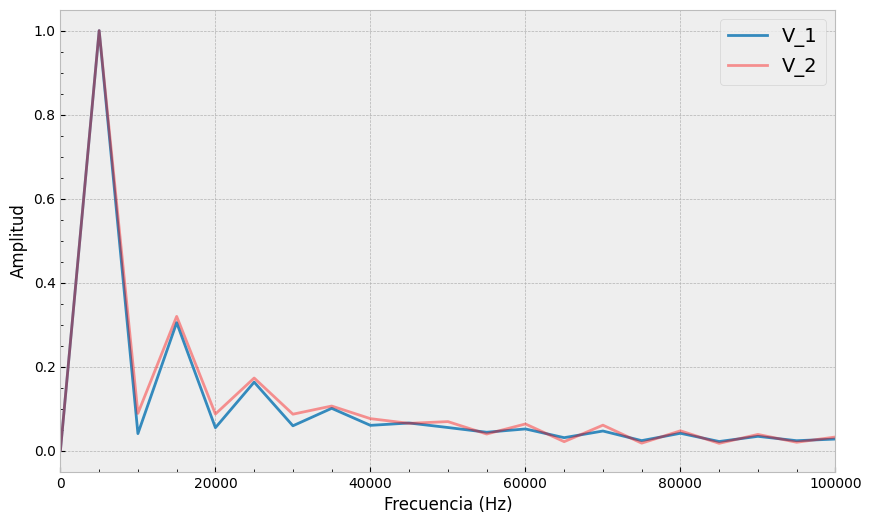

In [26]:
fig,axs = plt.subplots(ncols = 1, figsize = (10,6))


axs.plot(frec_1[tf_1 > 0.0], tf_1[tf_1 > 0.0], label='V_1')
axs.plot(frec_2[tf_2 > 0.0], tf_2[tf_2 > 0.0], label='V_2', color = "r", alpha = 0.4)
axs.set_xlabel('Frecuencia (Hz)')
axs.set_ylabel('Amplitud')
axs.set_xlim(0,100000)
axs.legend(fontsize = 14)

plt.show()

Calculamos los picos

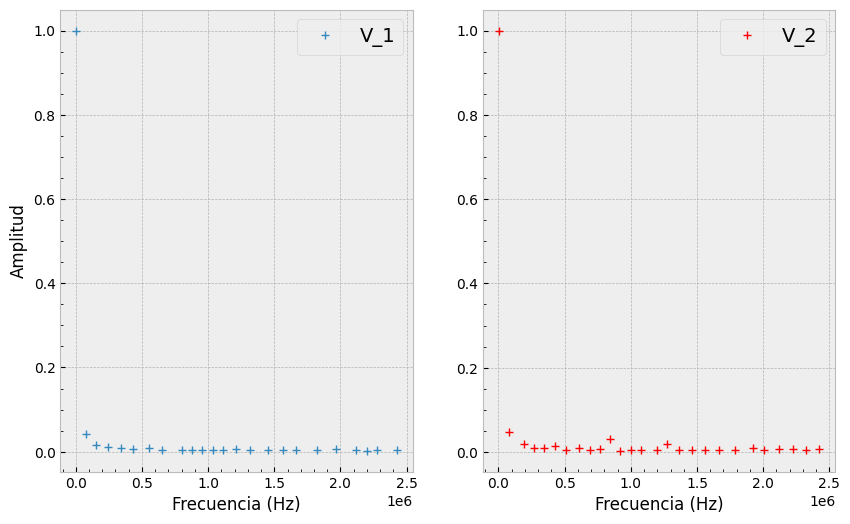

In [27]:
frec_1_peaks, tf_1_peaks = calculate_fourier_freqs(t_1, V_1)
frec_2_peaks, tf_2_peaks = calculate_fourier_freqs(t_2, V_2)


fig,axs = plt.subplots(ncols = 2, figsize = (10,6))

axs[0].plot(frec_1_peaks,tf_1_peaks,"+", label = "V_1")
axs[1].plot(frec_2_peaks,tf_2_peaks,"+", label = "V_2", color = "r")
#axs[0].set_xscale("log")
#axs[1].set_xscale("log")
axs[0].set_xlabel("Frecuencia (Hz)")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[0].set_ylabel("Amplitud")
axs[0].legend(fontsize = 14)
axs[1].legend(fontsize = 14)
plt.show()

In [28]:
print(frec_2_peaks)

[   5000.   80000.  190000.  265000.  345000.  425000.  510000.  605000.
  690000.  765000.  845000.  920000. 1000000. 1080000. 1195000. 1270000.
 1365000. 1465000. 1560000. 1670000. 1785000. 1920000. 2005000. 2120000.
 2225000. 2320000. 2425000.]


In [29]:
print(f"El tiempo de respuesta es de {1/frec_2_peaks[-1]*1000} ms")

El tiempo de respuesta es de 0.0004123711340206185 ms
